# Long Short-Term Memory (LSTM)

Las redes LSTM son muy eficientes para datos secuenciales, donde el orden importa. Piensa en texto (una secuencia de palabras), series temporales (precios de acciones a lo largo del tiempo o temperatura) o audio.

Tienen un "estado interno" o "memoria" que se actualiza en cada paso de la secuencia. Esto les permite recordar información de pasos anteriores para tomar decisiones en el presente. 

Ejemplos: Predecir la siguiente palabra en una oración, clasificar el sentimiento de una reseña de película, o predecir el clima de mañana basándose en los datos de la última semana.

### Dataset
Crearemos uno: una simple onda senoidal. Esto es ideal porque es un patrón periódico y predecible, lo que nos permite verificar visualmente si nuestro modelo está aprendiendo correctamente.

In [1]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.model_selection import LeaveOneGroupOut
from tensorflow.keras import Input
import pandas as pd
import numpy as np
import tensorflow as tf

In [2]:
def create_subject_sequences(X, y, subjects, window_size=10, stride=1):
    """
    Genera secuencias tipo sliding window de largo window_size
    para cada sujeto por separado.

    Parámetros:
        X: np.ndarray de forma (N, F) con todas las muestras
        y: np.ndarray de forma (N,) con etiquetas bin. por muestra
        subjects: np.ndarray de forma (N,) con id de sujeto por muestra
        window_size: int, número de filas por secuencia
        stride: int, paso entre ventanas deslizantes

    Devuelve:
        X_seq: np.ndarray (M, window_size, F)
        y_seq: np.ndarray (M,)          -- etiqueta de la última muestra de cada ventana
        subj_seq: np.ndarray (M,)       -- id de sujeto de cada secuencia
    """
    X_seqs, y_seqs, subj_seqs = [], [], []
    for subj in np.unique(subjects):
        mask = (subjects == subj)
        X_subj = X[mask]
        y_subj = y[mask]

        # ⚠️ Normalización z-score por sujeto
        mean = np.mean(X_subj, axis=0)
        std = np.std(X_subj, axis=0)
        std[std == 0] = 1  # Evitar división por cero
        X_subj = (X_subj - mean) / std

        L = len(X_subj)
        if L < window_size:
            continue

        # ventanas con stride configurable
        for start in range(0, L - window_size + 1, stride):
            end = start + window_size
            X_seqs.append(X_subj[start:end])
            y_seqs.append(y_subj[end - 1])
            subj_seqs.append(subj)

    return np.array(X_seqs), np.array(y_seqs), np.array(subj_seqs)


In [3]:
df = pd.read_csv(r'features_30_075\features.csv', index_col=0)

In [4]:
for i in range(1, len(df['label'].unique())+1):
    mask = (df['label'] == i).sum()
    print(f'Label: {i} total: {mask}')

Label: 1 total: 73554
Label: 2 total: 48333
Label: 3 total: 42875
Label: 4 total: 43068
Label: 5 total: 13228


In [5]:
# Filtrar los que sean 2
df = df[df['label'] != 2]

# Reasignar las clases
df['label'] = df['label'].apply(lambda x: 0 if x in [1, 5] else 1)

In [6]:
for i in range(0, len(df['label'].unique())):
    mask = (df['label'] == i).sum()
    print(f'Label: {i} total: {mask}')

Label: 0 total: 86782
Label: 1 total: 85943


In [7]:
feature_cols = [col for col in df.columns if col not in ['label', 'subject']]

In [8]:
X = df[feature_cols].values
y = df['label'].values
subjects = df['subject'].values

import numpy as np
import pandas as pd

df_temp = pd.DataFrame({
    'subject': np.ravel(subjects),
    'label': np.ravel(y)
})

# Contar clases únicas por sujeto
clases_por_sujeto = df_temp.groupby('subject')['label'].nunique()

# Filtrar sujetos que tienen ambas clases (0 y 1)
sujetos_validos = clases_por_sujeto[clases_por_sujeto == 2].index.tolist()

# Obtener índices válidos
indices_validos = df_temp['subject'].isin(sujetos_validos)

# Filtrar X, y, subjects
X_filtrado = X[indices_validos]
y_filtrado = y[indices_validos]
subjects_filtrados = subjects[indices_validos]

from sklearn.preprocessing import RobustScaler

# Suponiendo que ya tienes X, y, subjects
scaler = RobustScaler()
X_scaled = scaler.fit_transform(X_filtrado)

print(X_scaled.shape)  # (num_samples, seq_len, num_features)
print(y_filtrado.shape)

(137712, 52)
(137712,)


In [9]:
X_seq, y_seq, subj_seq = create_subject_sequences(X_scaled, y_filtrado, subjects_filtrados, window_size=10, stride=5)

In [10]:
print(X_seq.shape)

(27506, 10, 52)


In [11]:
print("GPUs disponibles:", tf.config.list_physical_devices('GPU'))

GPUs disponibles: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


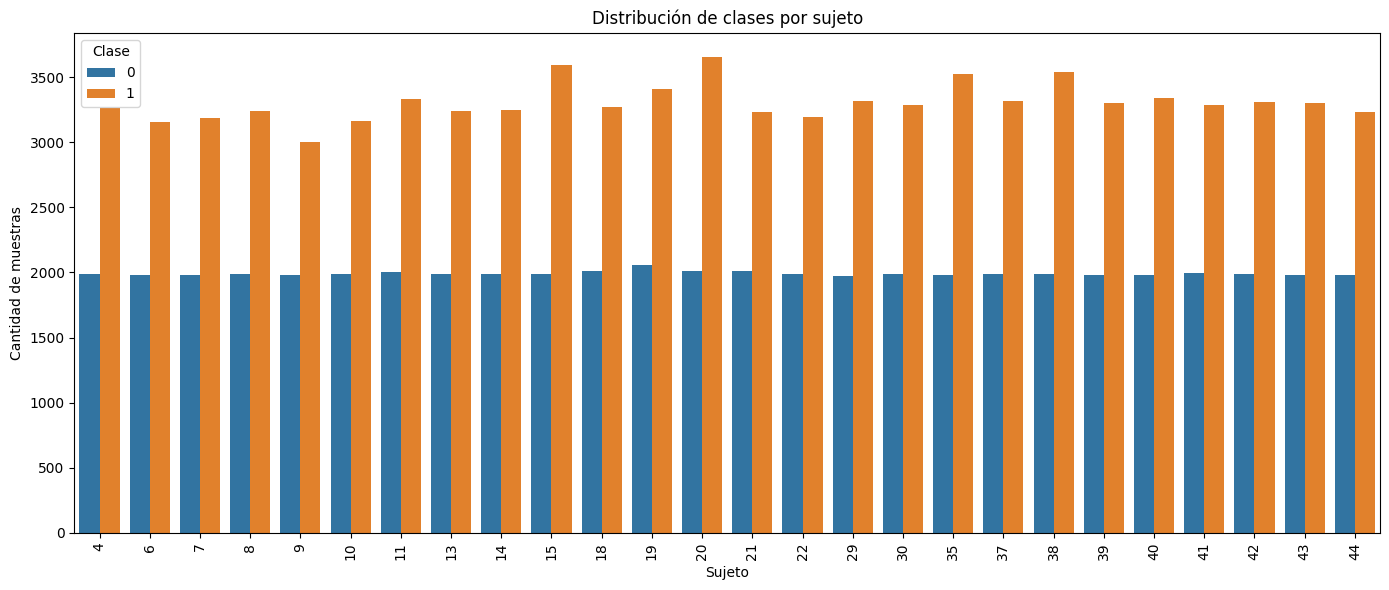

In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Asegurar que son arrays 1D
subjects_flat = np.ravel(subjects_filtrados)
y_flat = np.ravel(y_filtrado)

# Crear DataFrame temporal para análisis
df_temp = pd.DataFrame({
    'subject': subjects_flat,
    'label': y_flat
})

# Contar clases por sujeto
counts = df_temp.groupby(['subject', 'label']).size().reset_index(name='count')

# Gráfico de barras
plt.figure(figsize=(14, 6))
sns.barplot(data=counts, x='subject', y='count', hue='label')
plt.title('Distribución de clases por sujeto')
plt.xlabel('Sujeto')
plt.ylabel('Cantidad de muestras')
plt.xticks(rotation=90)
plt.legend(title='Clase')
plt.tight_layout()
plt.show()


🧪 Validando grupo 1 de 37
Clases en test (sujeto 1): {0: 396, 1: 652}
Epoch 1/50
414/414 [==============================] - 6s 4ms/step - loss: 0.7222 - accuracy: 0.5987 - val_loss: 0.6799 - val_accuracy: 0.5592

Epoch 00001: val_accuracy improved from -inf to 0.55916, saving model to modelos\mejor_modelo_1.h5
Epoch 2/50
414/414 [==============================] - 1s 3ms/step - loss: 0.6196 - accuracy: 0.7130 - val_loss: 0.5865 - val_accuracy: 0.7796

Epoch 00002: val_accuracy improved from 0.55916 to 0.77958, saving model to modelos\mejor_modelo_1.h5
Epoch 3/50
414/414 [==============================] - 1s 3ms/step - loss: 0.5377 - accuracy: 0.7976 - val_loss: 0.5031 - val_accuracy: 0.8712

Epoch 00003: val_accuracy improved from 0.77958 to 0.87118, saving model to modelos\mejor_modelo_1.h5
Epoch 4/50
414/414 [==============================] - 1s 3ms/step - loss: 0.4664 - accuracy: 0.8393 - val_loss: 0.4349 - val_accuracy: 0.8893

Epoch 00004: val_accuracy improved from 0.87118 to 0.8

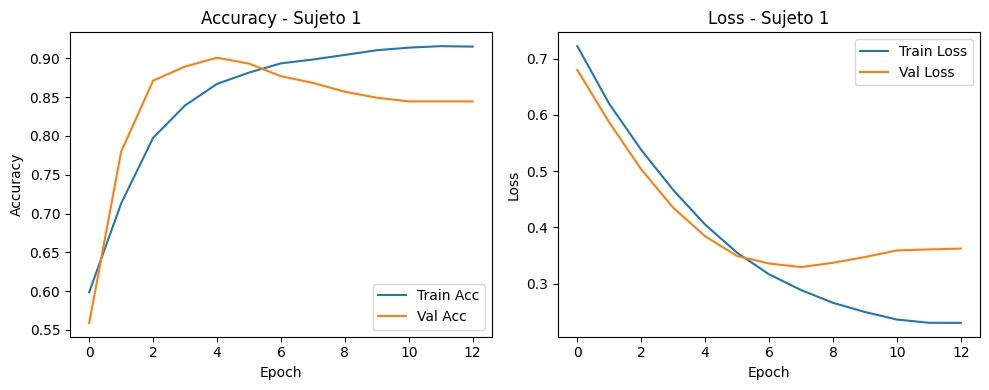

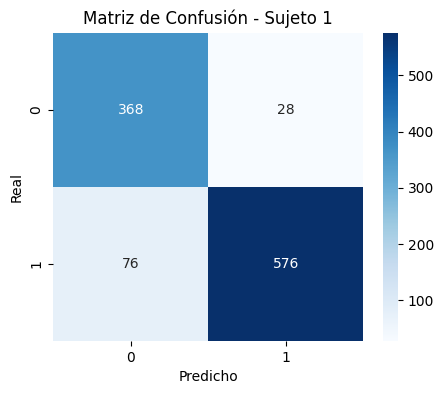

📄 Reporte de clasificación - Sujeto 1
              precision    recall  f1-score   support

           0     0.8288    0.9293    0.8762       396
           1     0.9536    0.8834    0.9172       652

    accuracy                         0.9008      1048
   macro avg     0.8912    0.9064    0.8967      1048
weighted avg     0.9065    0.9008    0.9017      1048


🧪 Validando grupo 2 de 37
Clases en test (sujeto 2): {0: 395, 1: 631}
Epoch 1/50
414/414 [==============================] - 2s 3ms/step - loss: 0.6762 - accuracy: 0.6218 - val_loss: 0.6634 - val_accuracy: 0.6316

Epoch 00001: val_accuracy improved from -inf to 0.63158, saving model to modelos\mejor_modelo_2.h5
Epoch 2/50
414/414 [==============================] - 1s 3ms/step - loss: 0.5896 - accuracy: 0.7663 - val_loss: 0.5955 - val_accuracy: 0.7827

Epoch 00002: val_accuracy improved from 0.63158 to 0.78265, saving model to modelos\mejor_modelo_2.h5
Epoch 3/50
414/414 [==============================] - 1s 3ms/step - loss: 0.5

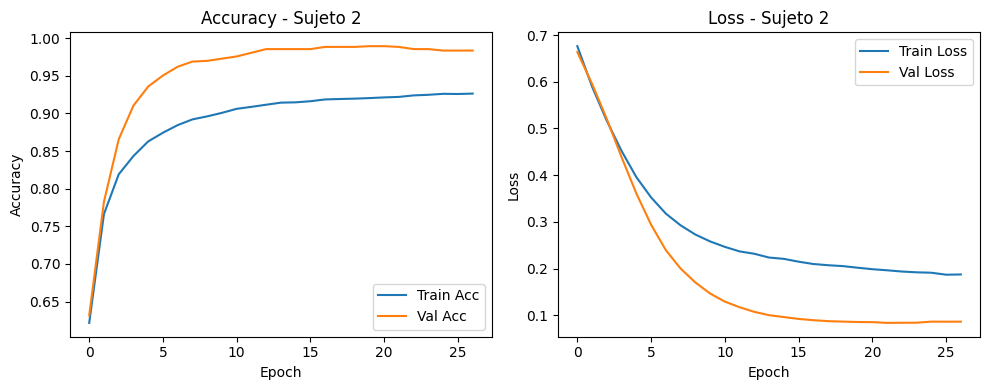

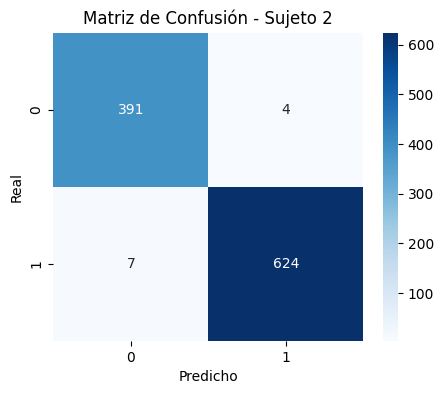

📄 Reporte de clasificación - Sujeto 2
              precision    recall  f1-score   support

           0     0.9824    0.9899    0.9861       395
           1     0.9936    0.9889    0.9913       631

    accuracy                         0.9893      1026
   macro avg     0.9880    0.9894    0.9887      1026
weighted avg     0.9893    0.9893    0.9893      1026


🧪 Validando grupo 3 de 37
Clases en test (sujeto 3): {0: 394, 1: 637}
Epoch 1/50
414/414 [==============================] - 2s 4ms/step - loss: 0.6322 - accuracy: 0.6255 - val_loss: 0.5967 - val_accuracy: 0.7226

Epoch 00001: val_accuracy improved from -inf to 0.72260, saving model to modelos\mejor_modelo_3.h5
Epoch 2/50
414/414 [==============================] - 1s 3ms/step - loss: 0.5493 - accuracy: 0.7628 - val_loss: 0.5068 - val_accuracy: 0.8448

Epoch 00002: val_accuracy improved from 0.72260 to 0.84481, saving model to modelos\mejor_modelo_3.h5
Epoch 3/50
414/414 [==============================] - 1s 3ms/step - loss: 0.4

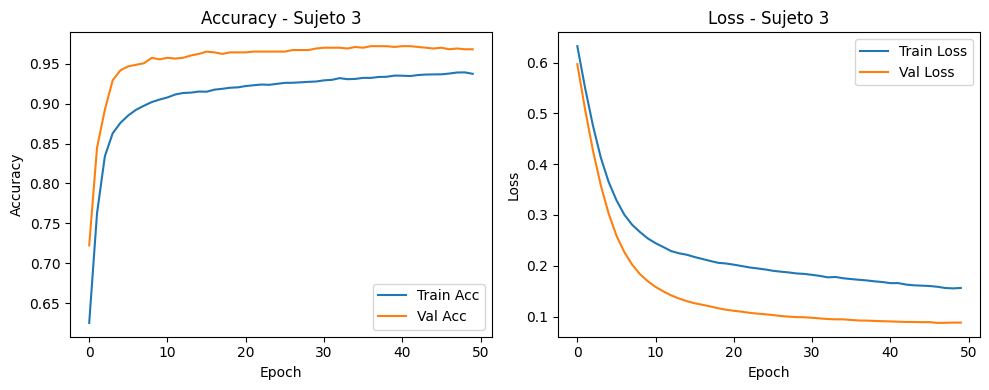

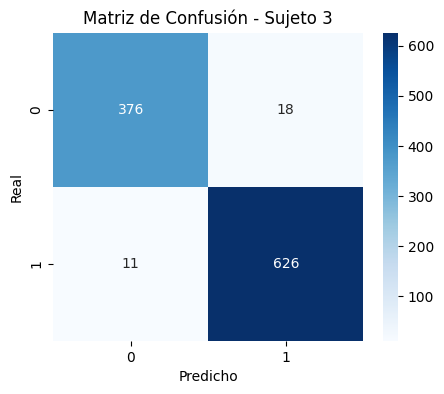

📄 Reporte de clasificación - Sujeto 3
              precision    recall  f1-score   support

           0     0.9716    0.9543    0.9629       394
           1     0.9720    0.9827    0.9774       637

    accuracy                         0.9719      1031
   macro avg     0.9718    0.9685    0.9701      1031
weighted avg     0.9719    0.9719    0.9718      1031


🧪 Validando grupo 4 de 37
Clases en test (sujeto 4): {0: 396, 1: 648}
Epoch 1/50
414/414 [==============================] - 3s 4ms/step - loss: 0.6973 - accuracy: 0.5803 - val_loss: 0.5828 - val_accuracy: 0.7653

Epoch 00001: val_accuracy improved from -inf to 0.76533, saving model to modelos\mejor_modelo_4.h5
Epoch 2/50
414/414 [==============================] - 1s 3ms/step - loss: 0.6071 - accuracy: 0.7048 - val_loss: 0.5227 - val_accuracy: 0.8123

Epoch 00002: val_accuracy improved from 0.76533 to 0.81226, saving model to modelos\mejor_modelo_4.h5
Epoch 3/50
414/414 [==============================] - 1s 3ms/step - loss: 0.5

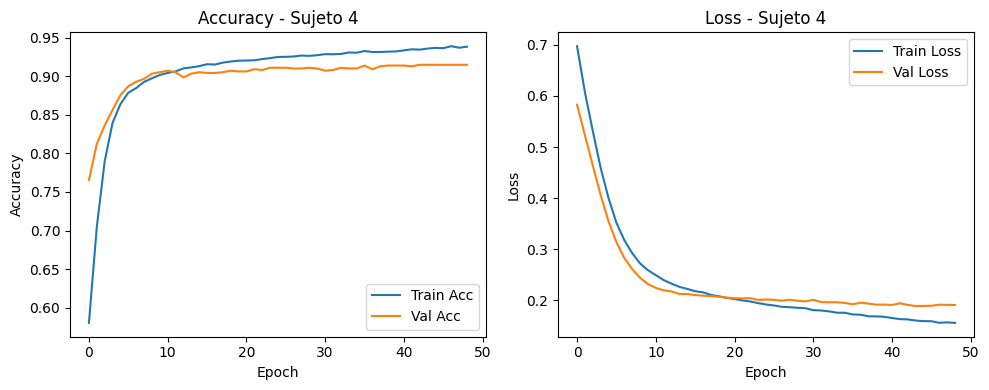

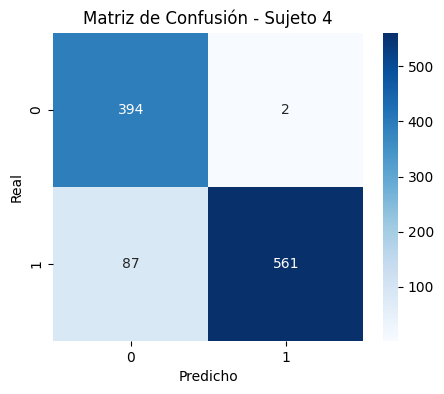

📄 Reporte de clasificación - Sujeto 4
              precision    recall  f1-score   support

           0     0.8191    0.9949    0.8985       396
           1     0.9964    0.8657    0.9265       648

    accuracy                         0.9148      1044
   macro avg     0.9078    0.9303    0.9125      1044
weighted avg     0.9292    0.9148    0.9159      1044


🧪 Validando grupo 5 de 37
Clases en test (sujeto 5): {0: 395, 1: 600}
Epoch 1/50
415/415 [==============================] - 3s 4ms/step - loss: 0.6551 - accuracy: 0.6606 - val_loss: 0.5436 - val_accuracy: 0.8673

Epoch 00001: val_accuracy improved from -inf to 0.86734, saving model to modelos\mejor_modelo_5.h5
Epoch 2/50
415/415 [==============================] - 1s 3ms/step - loss: 0.5682 - accuracy: 0.7619 - val_loss: 0.4355 - val_accuracy: 0.9397

Epoch 00002: val_accuracy improved from 0.86734 to 0.93970, saving model to modelos\mejor_modelo_5.h5
Epoch 3/50
415/415 [==============================] - 1s 3ms/step - loss: 0.4

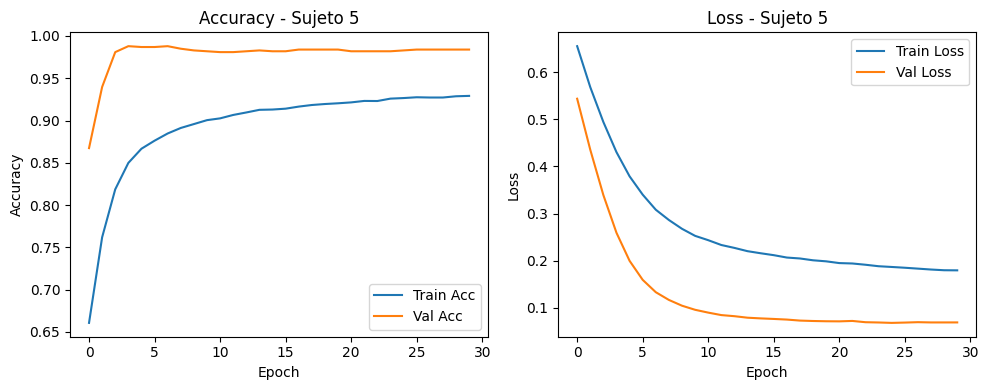

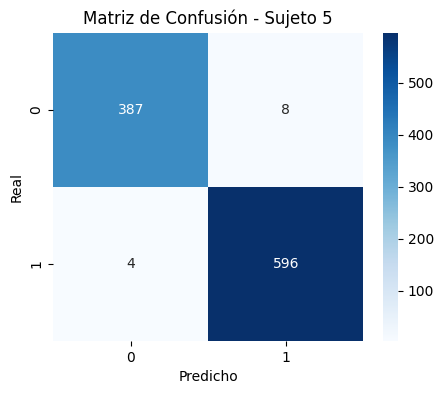

📄 Reporte de clasificación - Sujeto 5
              precision    recall  f1-score   support

           0     0.9898    0.9797    0.9847       395
           1     0.9868    0.9933    0.9900       600

    accuracy                         0.9879       995
   macro avg     0.9883    0.9865    0.9874       995
weighted avg     0.9880    0.9879    0.9879       995


🧪 Validando grupo 6 de 37
Clases en test (sujeto 6): {0: 396, 1: 632}
Epoch 1/50
414/414 [==============================] - 2s 4ms/step - loss: 0.6401 - accuracy: 0.7109 - val_loss: 0.6181 - val_accuracy: 0.7150

Epoch 00001: val_accuracy improved from -inf to 0.71498, saving model to modelos\mejor_modelo_6.h5
Epoch 2/50
414/414 [==============================] - 1s 3ms/step - loss: 0.5632 - accuracy: 0.7969 - val_loss: 0.5723 - val_accuracy: 0.7821

Epoch 00002: val_accuracy improved from 0.71498 to 0.78210, saving model to modelos\mejor_modelo_6.h5
Epoch 3/50
414/414 [==============================] - 1s 3ms/step - loss: 0.4

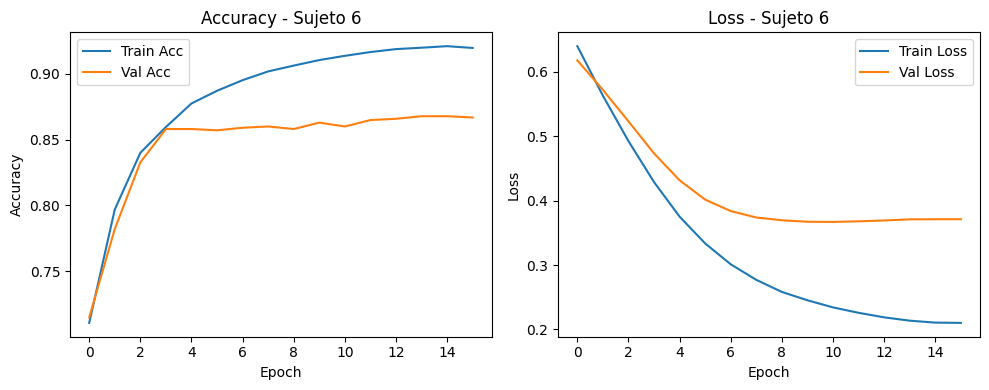

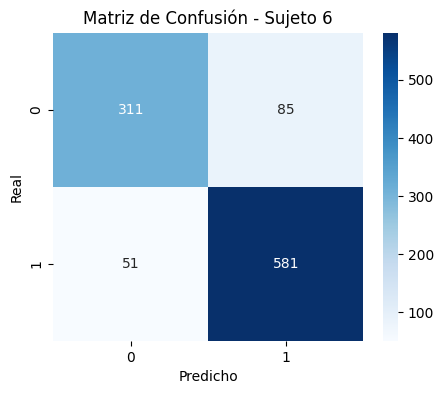

📄 Reporte de clasificación - Sujeto 6
              precision    recall  f1-score   support

           0     0.8591    0.7854    0.8206       396
           1     0.8724    0.9193    0.8952       632

    accuracy                         0.8677      1028
   macro avg     0.8657    0.8523    0.8579      1028
weighted avg     0.8673    0.8677    0.8665      1028


🧪 Validando grupo 7 de 37
Clases en test (sujeto 7): {0: 399, 1: 666}
Epoch 1/50
414/414 [==============================] - 3s 4ms/step - loss: 0.6849 - accuracy: 0.5263 - val_loss: 0.6250 - val_accuracy: 0.7080

Epoch 00001: val_accuracy improved from -inf to 0.70798, saving model to modelos\mejor_modelo_7.h5
Epoch 2/50
414/414 [==============================] - 1s 3ms/step - loss: 0.6057 - accuracy: 0.6823 - val_loss: 0.5392 - val_accuracy: 0.7859

Epoch 00002: val_accuracy improved from 0.70798 to 0.78592, saving model to modelos\mejor_modelo_7.h5
Epoch 3/50
414/414 [==============================] - 1s 3ms/step - loss: 0.5

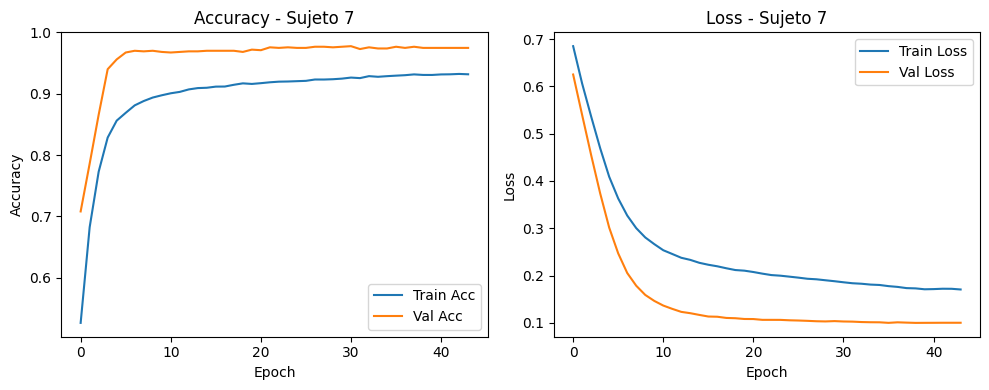

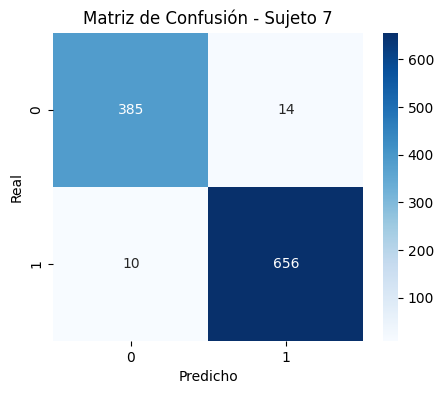

📄 Reporte de clasificación - Sujeto 7
              precision    recall  f1-score   support

           0     0.9747    0.9649    0.9698       399
           1     0.9791    0.9850    0.9820       666

    accuracy                         0.9775      1065
   macro avg     0.9769    0.9749    0.9759      1065
weighted avg     0.9774    0.9775    0.9774      1065


🧪 Validando grupo 8 de 37
Clases en test (sujeto 8): {0: 396, 1: 647}
Epoch 1/50
414/414 [==============================] - 3s 4ms/step - loss: 0.6597 - accuracy: 0.6171 - val_loss: 0.5917 - val_accuracy: 0.7728

Epoch 00001: val_accuracy improved from -inf to 0.77277, saving model to modelos\mejor_modelo_8.h5
Epoch 2/50
414/414 [==============================] - 1s 3ms/step - loss: 0.5636 - accuracy: 0.7685 - val_loss: 0.4932 - val_accuracy: 0.8495

Epoch 00002: val_accuracy improved from 0.77277 to 0.84947, saving model to modelos\mejor_modelo_8.h5
Epoch 3/50
414/414 [==============================] - 1s 3ms/step - loss: 0.4

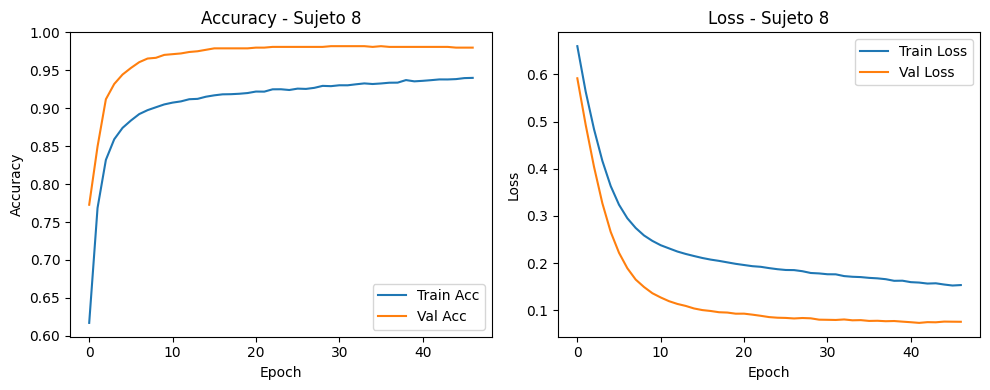

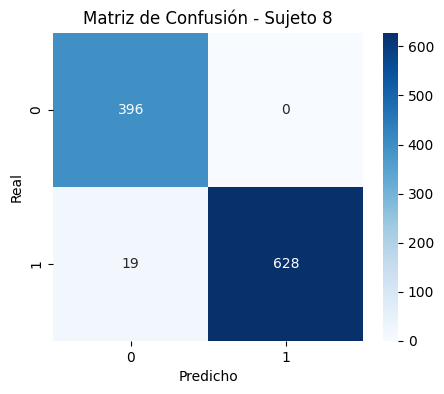

📄 Reporte de clasificación - Sujeto 8
              precision    recall  f1-score   support

           0     0.9542    1.0000    0.9766       396
           1     1.0000    0.9706    0.9851       647

    accuracy                         0.9818      1043
   macro avg     0.9771    0.9853    0.9808      1043
weighted avg     0.9826    0.9818    0.9819      1043


🧪 Validando grupo 9 de 37
Clases en test (sujeto 9): {0: 396, 1: 650}
Epoch 1/50
414/414 [==============================] - 3s 4ms/step - loss: 0.6322 - accuracy: 0.6224 - val_loss: 0.6072 - val_accuracy: 0.7390

Epoch 00001: val_accuracy improved from -inf to 0.73901, saving model to modelos\mejor_modelo_9.h5
Epoch 2/50
414/414 [==============================] - 1s 3ms/step - loss: 0.5551 - accuracy: 0.7583 - val_loss: 0.5193 - val_accuracy: 0.8289

Epoch 00002: val_accuracy improved from 0.73901 to 0.82887, saving model to modelos\mejor_modelo_9.h5
Epoch 3/50
414/414 [==============================] - 1s 3ms/step - loss: 0.4

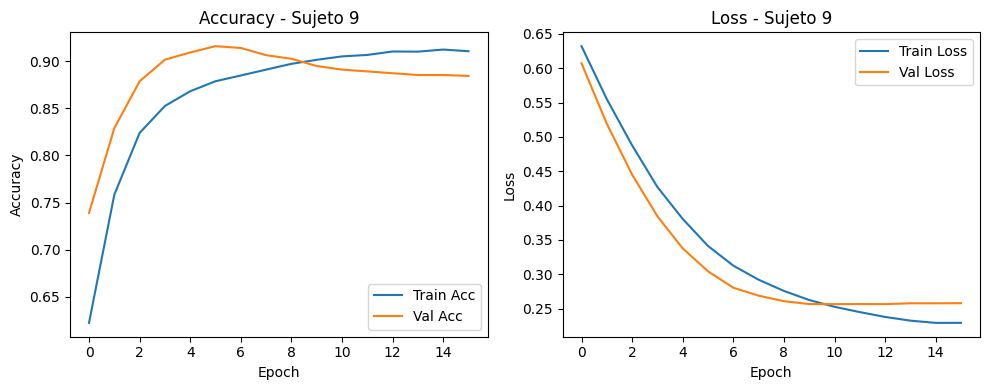

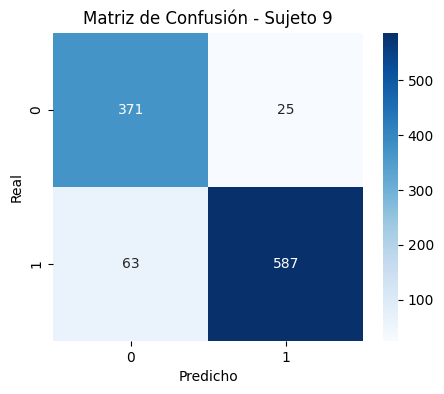

📄 Reporte de clasificación - Sujeto 9
              precision    recall  f1-score   support

           0     0.8548    0.9369    0.8940       396
           1     0.9592    0.9031    0.9303       650

    accuracy                         0.9159      1046
   macro avg     0.9070    0.9200    0.9121      1046
weighted avg     0.9197    0.9159    0.9165      1046


🧪 Validando grupo 10 de 37
Clases en test (sujeto 10): {0: 396, 1: 718}
Epoch 1/50
413/413 [==============================] - 2s 3ms/step - loss: 0.6793 - accuracy: 0.6109 - val_loss: 0.5901 - val_accuracy: 0.8303

Epoch 00001: val_accuracy improved from -inf to 0.83034, saving model to modelos\mejor_modelo_10.h5
Epoch 2/50
413/413 [==============================] - 1s 3ms/step - loss: 0.6057 - accuracy: 0.7401 - val_loss: 0.5053 - val_accuracy: 0.9066

Epoch 00002: val_accuracy improved from 0.83034 to 0.90664, saving model to modelos\mejor_modelo_10.h5
Epoch 3/50
413/413 [==============================] - 1s 3ms/step - loss:

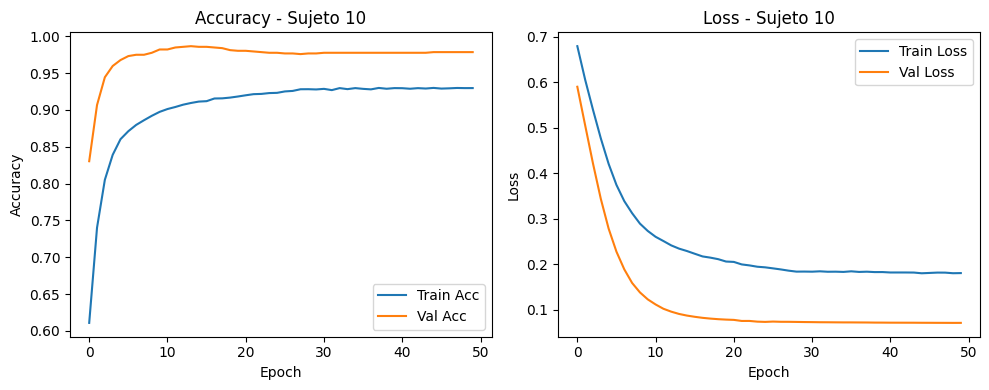

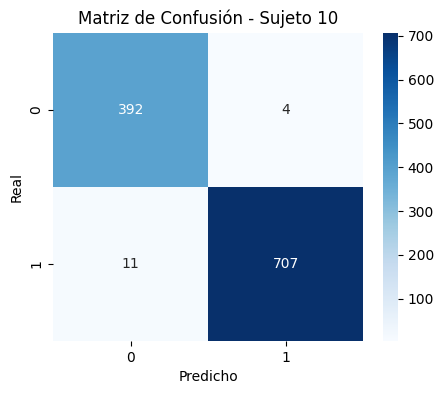

📄 Reporte de clasificación - Sujeto 10
              precision    recall  f1-score   support

           0     0.9727    0.9899    0.9812       396
           1     0.9944    0.9847    0.9895       718

    accuracy                         0.9865      1114
   macro avg     0.9835    0.9873    0.9854      1114
weighted avg     0.9867    0.9865    0.9866      1114


🧪 Validando grupo 11 de 37
Clases en test (sujeto 11): {0: 401, 1: 653}
Epoch 1/50
414/414 [==============================] - 2s 4ms/step - loss: 0.6709 - accuracy: 0.5025 - val_loss: 0.7044 - val_accuracy: 0.5408

Epoch 00001: val_accuracy improved from -inf to 0.54080, saving model to modelos\mejor_modelo_11.h5
Epoch 2/50
414/414 [==============================] - 1s 3ms/step - loss: 0.5790 - accuracy: 0.6740 - val_loss: 0.6478 - val_accuracy: 0.6082

Epoch 00002: val_accuracy improved from 0.54080 to 0.60816, saving model to modelos\mejor_modelo_11.h5
Epoch 3/50
414/414 [==============================] - 1s 3ms/step - loss

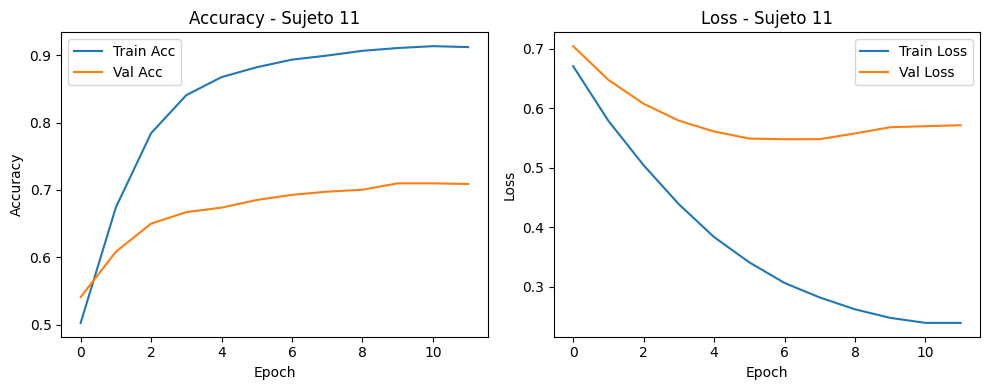

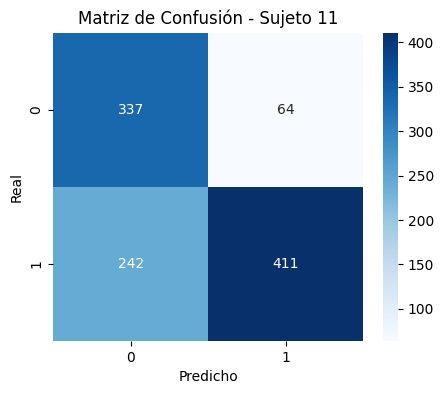

📄 Reporte de clasificación - Sujeto 11
              precision    recall  f1-score   support

           0     0.5820    0.8404    0.6878       401
           1     0.8653    0.6294    0.7287       653

    accuracy                         0.7097      1054
   macro avg     0.7237    0.7349    0.7082      1054
weighted avg     0.7575    0.7097    0.7131      1054


🧪 Validando grupo 12 de 37
Clases en test (sujeto 12): {0: 410, 1: 682}
Epoch 1/50
413/413 [==============================] - 2s 4ms/step - loss: 0.6711 - accuracy: 0.5707 - val_loss: 0.6020 - val_accuracy: 0.7445

Epoch 00001: val_accuracy improved from -inf to 0.74451, saving model to modelos\mejor_modelo_12.h5
Epoch 2/50
413/413 [==============================] - 1s 3ms/step - loss: 0.5990 - accuracy: 0.7091 - val_loss: 0.4950 - val_accuracy: 0.9112

Epoch 00002: val_accuracy improved from 0.74451 to 0.91117, saving model to modelos\mejor_modelo_12.h5
Epoch 3/50
413/413 [==============================] - 1s 3ms/step - loss

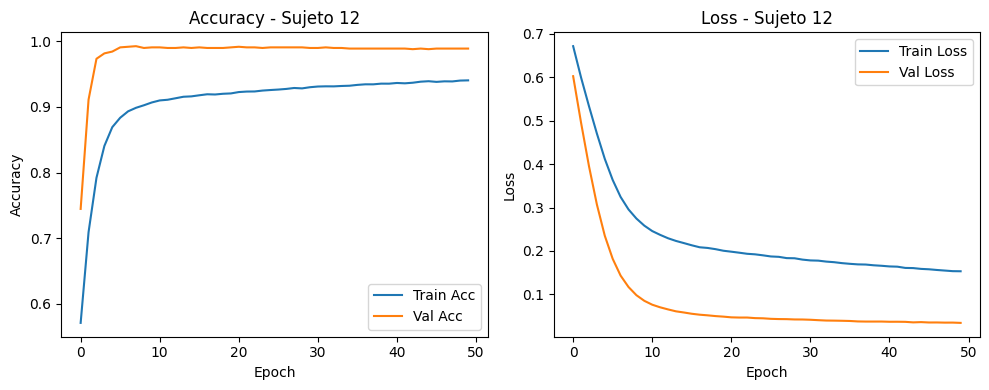

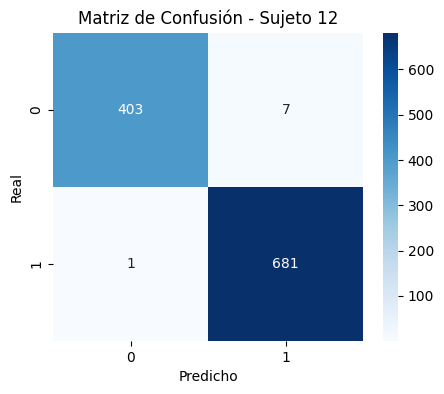

📄 Reporte de clasificación - Sujeto 12
              precision    recall  f1-score   support

           0     0.9975    0.9829    0.9902       410
           1     0.9898    0.9985    0.9942       682

    accuracy                         0.9927      1092
   macro avg     0.9937    0.9907    0.9922      1092
weighted avg     0.9927    0.9927    0.9927      1092


🧪 Validando grupo 13 de 37
Clases en test (sujeto 13): {0: 400, 1: 732}
Epoch 1/50
413/413 [==============================] - 2s 4ms/step - loss: 0.6743 - accuracy: 0.5793 - val_loss: 0.6321 - val_accuracy: 0.7465

Epoch 00001: val_accuracy improved from -inf to 0.74647, saving model to modelos\mejor_modelo_13.h5
Epoch 2/50
413/413 [==============================] - 1s 3ms/step - loss: 0.5959 - accuracy: 0.7502 - val_loss: 0.5338 - val_accuracy: 0.9117

Epoch 00002: val_accuracy improved from 0.74647 to 0.91166, saving model to modelos\mejor_modelo_13.h5
Epoch 3/50
413/413 [==============================] - 1s 3ms/step - loss

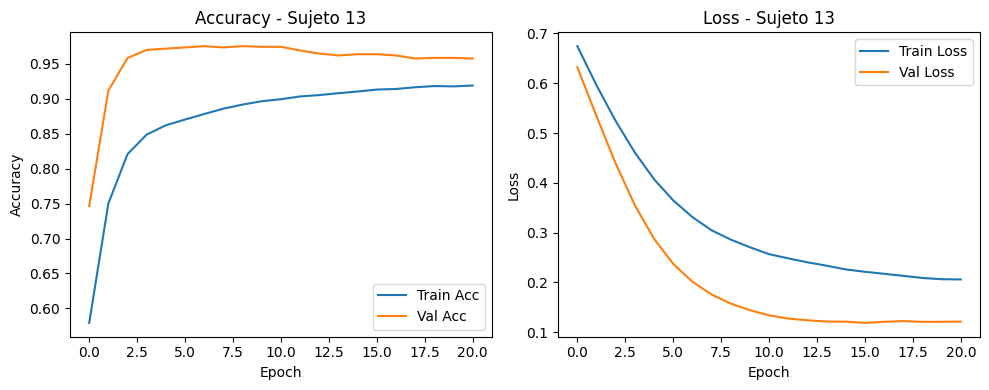

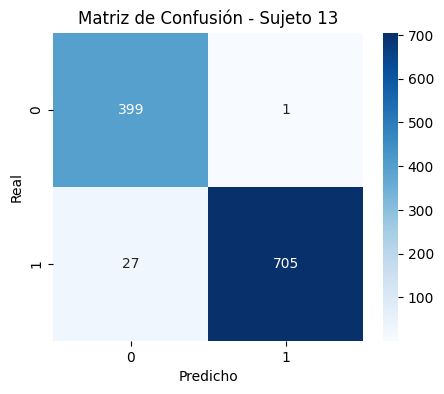

📄 Reporte de clasificación - Sujeto 13
              precision    recall  f1-score   support

           0     0.9366    0.9975    0.9661       400
           1     0.9986    0.9631    0.9805       732

    accuracy                         0.9753      1132
   macro avg     0.9676    0.9803    0.9733      1132
weighted avg     0.9767    0.9753    0.9754      1132


🧪 Validando grupo 14 de 37
Clases en test (sujeto 14): {0: 401, 1: 647}
Epoch 1/50
414/414 [==============================] - 2s 3ms/step - loss: 0.6434 - accuracy: 0.6731 - val_loss: 0.5559 - val_accuracy: 0.8931

Epoch 00001: val_accuracy improved from -inf to 0.89313, saving model to modelos\mejor_modelo_14.h5
Epoch 2/50
414/414 [==============================] - 1s 3ms/step - loss: 0.5701 - accuracy: 0.7764 - val_loss: 0.4646 - val_accuracy: 0.9399

Epoch 00002: val_accuracy improved from 0.89313 to 0.93989, saving model to modelos\mejor_modelo_14.h5
Epoch 3/50
414/414 [==============================] - 1s 3ms/step - loss

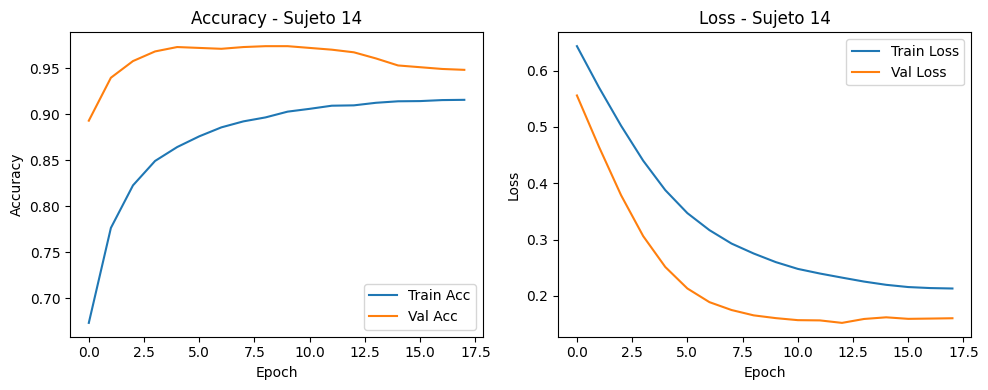

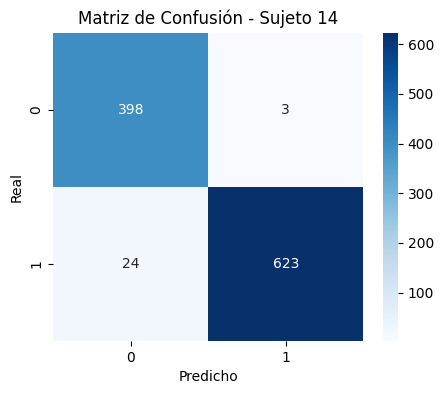

📄 Reporte de clasificación - Sujeto 14
              precision    recall  f1-score   support

           0     0.9431    0.9925    0.9672       401
           1     0.9952    0.9629    0.9788       647

    accuracy                         0.9742      1048
   macro avg     0.9692    0.9777    0.9730      1048
weighted avg     0.9753    0.9742    0.9744      1048


🧪 Validando grupo 15 de 37
Clases en test (sujeto 15): {0: 397, 1: 638}
Epoch 1/50
414/414 [==============================] - 2s 4ms/step - loss: 0.6498 - accuracy: 0.5994 - val_loss: 0.5761 - val_accuracy: 0.8116

Epoch 00001: val_accuracy improved from -inf to 0.81159, saving model to modelos\mejor_modelo_15.h5
Epoch 2/50
414/414 [==============================] - 1s 3ms/step - loss: 0.5764 - accuracy: 0.7373 - val_loss: 0.4750 - val_accuracy: 0.8879

Epoch 00002: val_accuracy improved from 0.81159 to 0.88792, saving model to modelos\mejor_modelo_15.h5
Epoch 3/50
414/414 [==============================] - 1s 3ms/step - loss

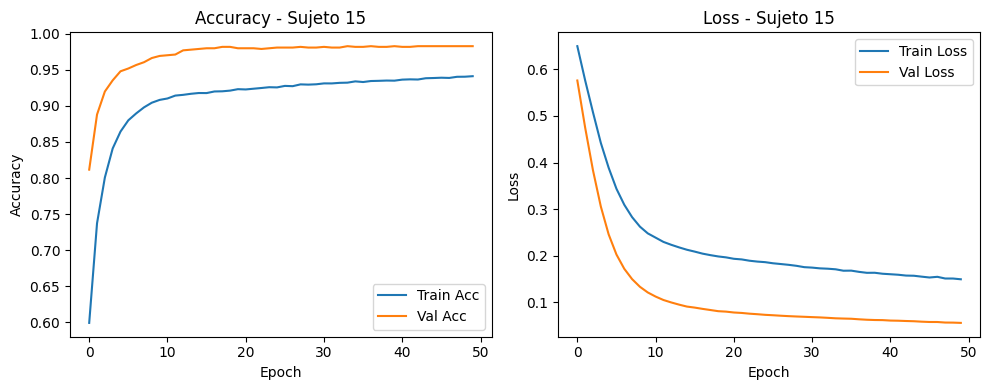

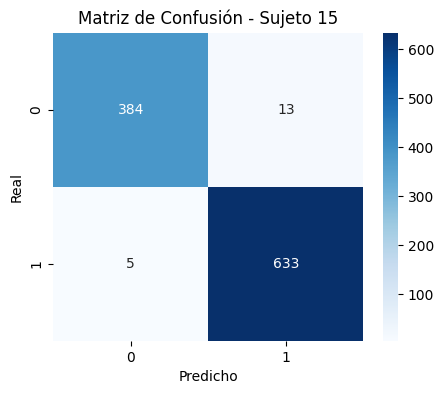

📄 Reporte de clasificación - Sujeto 15
              precision    recall  f1-score   support

           0     0.9871    0.9673    0.9771       397
           1     0.9799    0.9922    0.9860       638

    accuracy                         0.9826      1035
   macro avg     0.9835    0.9797    0.9815      1035
weighted avg     0.9827    0.9826    0.9826      1035


🧪 Validando grupo 16 de 37
Clases en test (sujeto 16): {0: 393, 1: 664}
Epoch 1/50
414/414 [==============================] - 3s 4ms/step - loss: 0.7213 - accuracy: 0.4954 - val_loss: 0.6944 - val_accuracy: 0.5147

Epoch 00001: val_accuracy improved from -inf to 0.51466, saving model to modelos\mejor_modelo_16.h5
Epoch 2/50
414/414 [==============================] - 1s 3ms/step - loss: 0.6289 - accuracy: 0.6828 - val_loss: 0.7118 - val_accuracy: 0.4882

Epoch 00002: val_accuracy did not improve from 0.51466
Epoch 3/50
414/414 [==============================] - 1s 3ms/step - loss: 0.5496 - accuracy: 0.7862 - val_loss: 0.7347 -

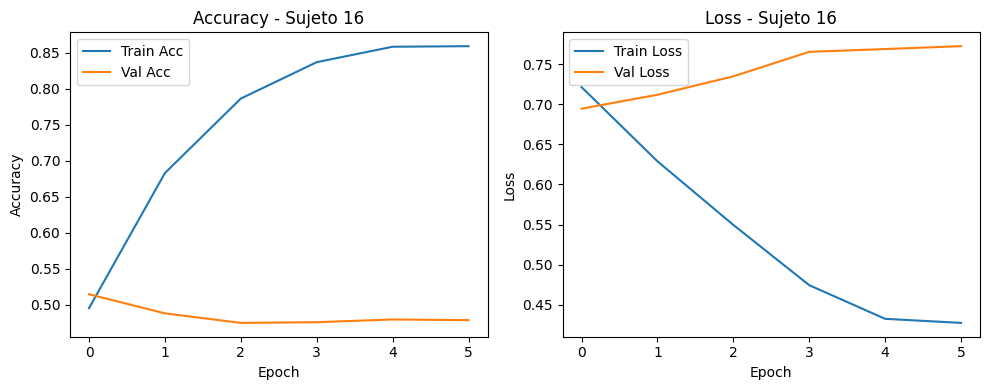

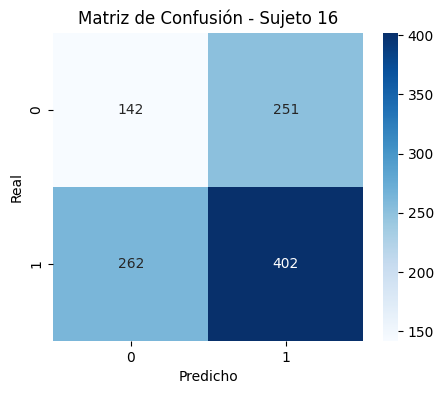

📄 Reporte de clasificación - Sujeto 16
              precision    recall  f1-score   support

           0     0.3515    0.3613    0.3563       393
           1     0.6156    0.6054    0.6105       664

    accuracy                         0.5147      1057
   macro avg     0.4836    0.4834    0.4834      1057
weighted avg     0.5174    0.5147    0.5160      1057


🧪 Validando grupo 17 de 37
Clases en test (sujeto 17): {0: 396, 1: 658}
Epoch 1/50
414/414 [==============================] - 2s 3ms/step - loss: 0.6355 - accuracy: 0.6999 - val_loss: 0.5246 - val_accuracy: 0.8491

Epoch 00001: val_accuracy improved from -inf to 0.84915, saving model to modelos\mejor_modelo_17.h5
Epoch 2/50
414/414 [==============================] - 1s 3ms/step - loss: 0.5546 - accuracy: 0.7941 - val_loss: 0.4654 - val_accuracy: 0.8548

Epoch 00002: val_accuracy improved from 0.84915 to 0.85484, saving model to modelos\mejor_modelo_17.h5
Epoch 3/50
414/414 [==============================] - 1s 3ms/step - loss

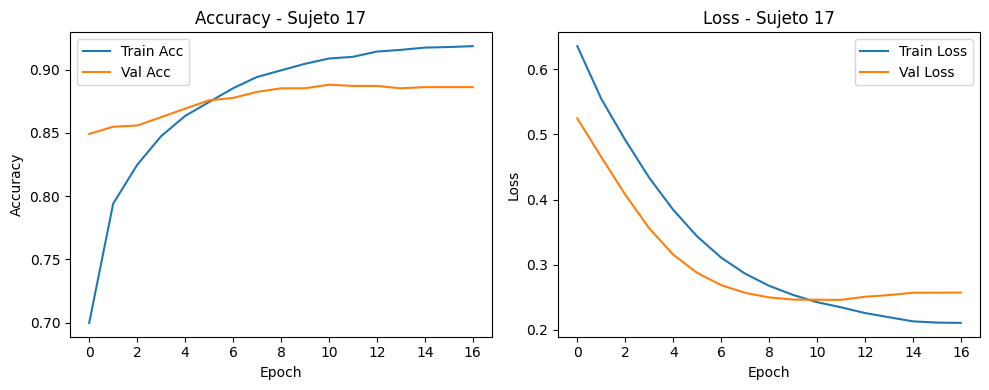

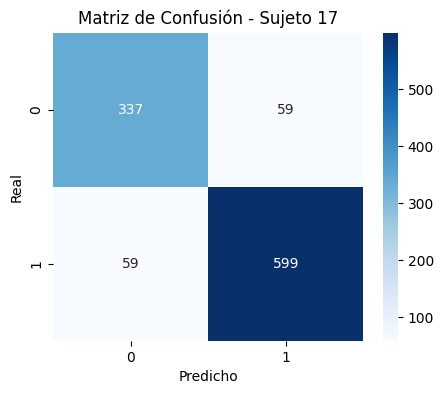

📄 Reporte de clasificación - Sujeto 17
              precision    recall  f1-score   support

           0     0.8510    0.8510    0.8510       396
           1     0.9103    0.9103    0.9103       658

    accuracy                         0.8880      1054
   macro avg     0.8807    0.8807    0.8807      1054
weighted avg     0.8880    0.8880    0.8880      1054


🧪 Validando grupo 18 de 37
Clases en test (sujeto 18): {0: 395, 1: 705}
Epoch 1/50
413/413 [==============================] - 3s 4ms/step - loss: 0.6798 - accuracy: 0.5846 - val_loss: 0.7217 - val_accuracy: 0.5182

Epoch 00001: val_accuracy improved from -inf to 0.51818, saving model to modelos\mejor_modelo_18.h5
Epoch 2/50
413/413 [==============================] - 1s 3ms/step - loss: 0.5947 - accuracy: 0.7381 - val_loss: 0.6955 - val_accuracy: 0.5873

Epoch 00002: val_accuracy improved from 0.51818 to 0.58727, saving model to modelos\mejor_modelo_18.h5
Epoch 3/50
413/413 [==============================] - 1s 3ms/step - loss

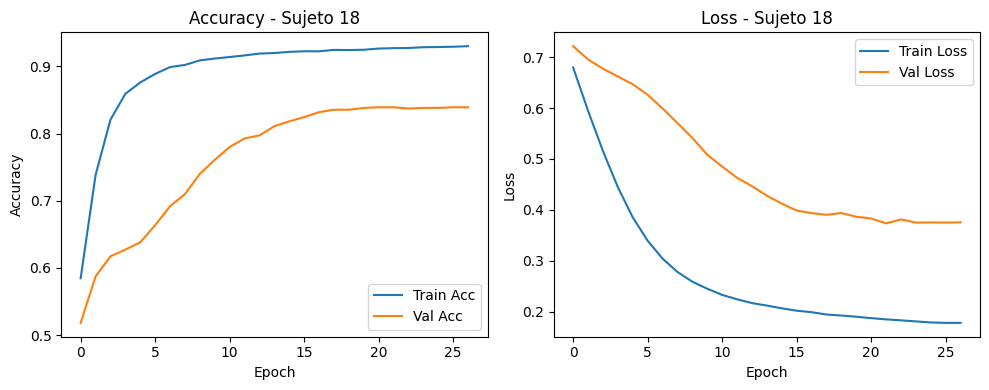

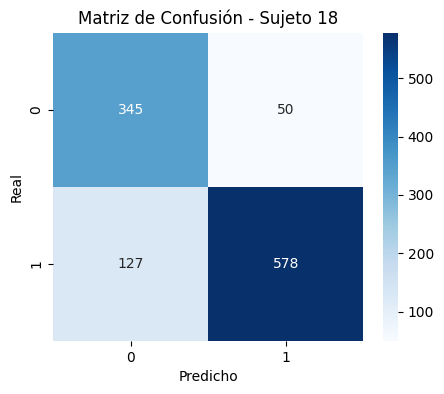

📄 Reporte de clasificación - Sujeto 18
              precision    recall  f1-score   support

           0     0.7309    0.8734    0.7958       395
           1     0.9204    0.8199    0.8672       705

    accuracy                         0.8391      1100
   macro avg     0.8257    0.8466    0.8315      1100
weighted avg     0.8524    0.8391    0.8416      1100


🧪 Validando grupo 19 de 37
Clases en test (sujeto 19): {0: 396, 1: 663}
Epoch 1/50
414/414 [==============================] - 2s 3ms/step - loss: 0.6445 - accuracy: 0.6749 - val_loss: 0.6248 - val_accuracy: 0.6308

Epoch 00001: val_accuracy improved from -inf to 0.63078, saving model to modelos\mejor_modelo_19.h5
Epoch 2/50
414/414 [==============================] - 1s 3ms/step - loss: 0.5588 - accuracy: 0.7969 - val_loss: 0.6164 - val_accuracy: 0.6176

Epoch 00002: val_accuracy did not improve from 0.63078
Epoch 3/50
414/414 [==============================] - 1s 3ms/step - loss: 0.4873 - accuracy: 0.8416 - val_loss: 0.6053 -

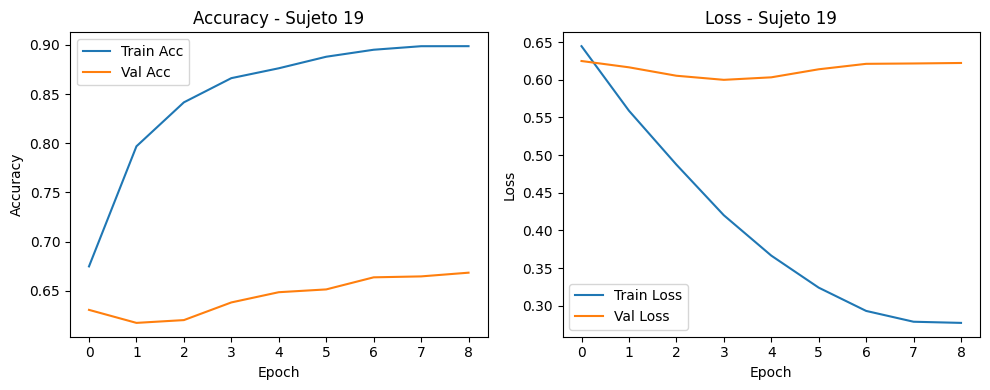

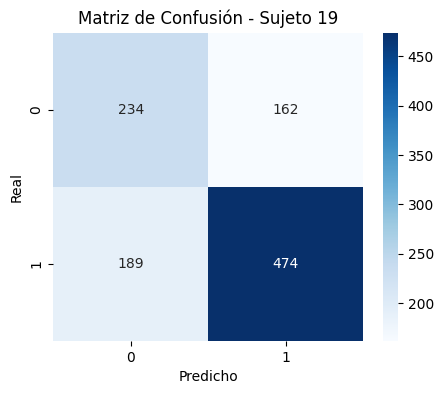

📄 Reporte de clasificación - Sujeto 19
              precision    recall  f1-score   support

           0     0.5532    0.5909    0.5714       396
           1     0.7453    0.7149    0.7298       663

    accuracy                         0.6686      1059
   macro avg     0.6492    0.6529    0.6506      1059
weighted avg     0.6735    0.6686    0.6706      1059


🧪 Validando grupo 20 de 37
Clases en test (sujeto 20): {0: 396, 1: 707}
Epoch 1/50
413/413 [==============================] - 2s 4ms/step - loss: 0.6406 - accuracy: 0.6762 - val_loss: 0.5600 - val_accuracy: 0.8586

Epoch 00001: val_accuracy improved from -inf to 0.85857, saving model to modelos\mejor_modelo_20.h5
Epoch 2/50
413/413 [==============================] - 1s 3ms/step - loss: 0.5579 - accuracy: 0.7895 - val_loss: 0.4776 - val_accuracy: 0.8867

Epoch 00002: val_accuracy improved from 0.85857 to 0.88667, saving model to modelos\mejor_modelo_20.h5
Epoch 3/50
413/413 [==============================] - 1s 3ms/step - loss

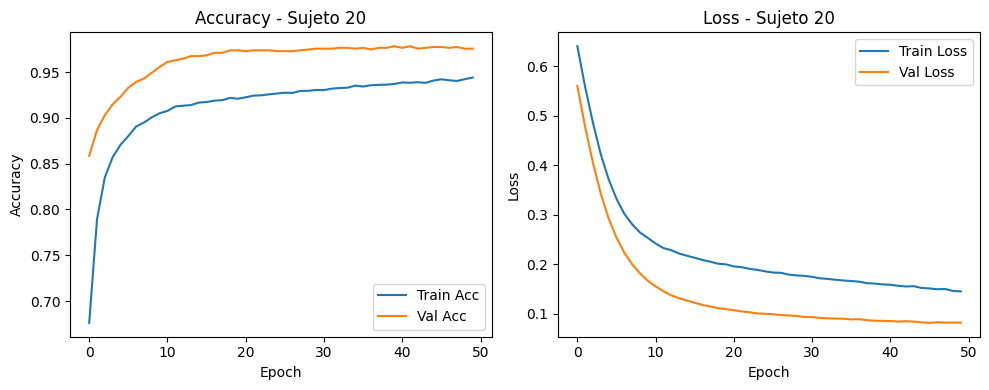

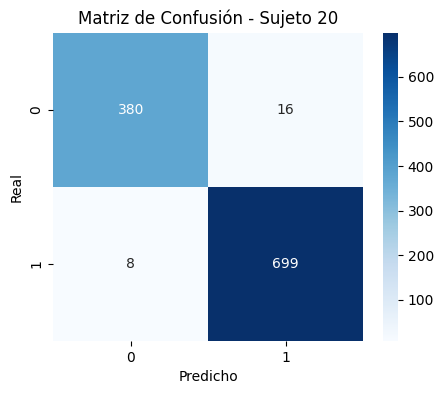

📄 Reporte de clasificación - Sujeto 20
              precision    recall  f1-score   support

           0     0.9794    0.9596    0.9694       396
           1     0.9776    0.9887    0.9831       707

    accuracy                         0.9782      1103
   macro avg     0.9785    0.9741    0.9763      1103
weighted avg     0.9783    0.9782    0.9782      1103


🧪 Validando grupo 21 de 37
Clases en test (sujeto 21): {0: 395, 1: 661}
Epoch 1/50
414/414 [==============================] - 2s 4ms/step - loss: 0.6944 - accuracy: 0.5921 - val_loss: 0.6680 - val_accuracy: 0.6402

Epoch 00001: val_accuracy improved from -inf to 0.64015, saving model to modelos\mejor_modelo_21.h5
Epoch 2/50
414/414 [==============================] - 1s 3ms/step - loss: 0.5884 - accuracy: 0.7568 - val_loss: 0.5830 - val_accuracy: 0.7907

Epoch 00002: val_accuracy improved from 0.64015 to 0.79072, saving model to modelos\mejor_modelo_21.h5
Epoch 3/50
414/414 [==============================] - 1s 3ms/step - loss

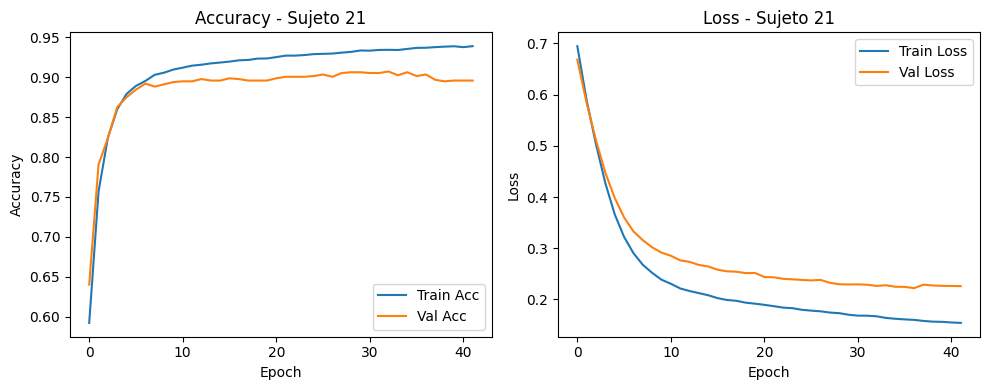

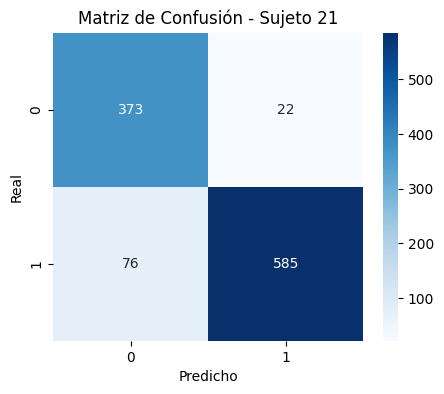

📄 Reporte de clasificación - Sujeto 21
              precision    recall  f1-score   support

           0     0.8307    0.9443    0.8839       395
           1     0.9638    0.8850    0.9227       661

    accuracy                         0.9072      1056
   macro avg     0.8972    0.9147    0.9033      1056
weighted avg     0.9140    0.9072    0.9082      1056


🧪 Validando grupo 22 de 37
Clases en test (sujeto 22): {0: 395, 1: 668}
Epoch 1/50
414/414 [==============================] - 2s 3ms/step - loss: 0.6868 - accuracy: 0.5352 - val_loss: 0.6115 - val_accuracy: 0.7545

Epoch 00001: val_accuracy improved from -inf to 0.75447, saving model to modelos\mejor_modelo_22.h5
Epoch 2/50
414/414 [==============================] - 1s 3ms/step - loss: 0.6008 - accuracy: 0.7318 - val_loss: 0.5191 - val_accuracy: 0.9069

Epoch 00002: val_accuracy improved from 0.75447 to 0.90687, saving model to modelos\mejor_modelo_22.h5
Epoch 3/50
414/414 [==============================] - 1s 3ms/step - loss

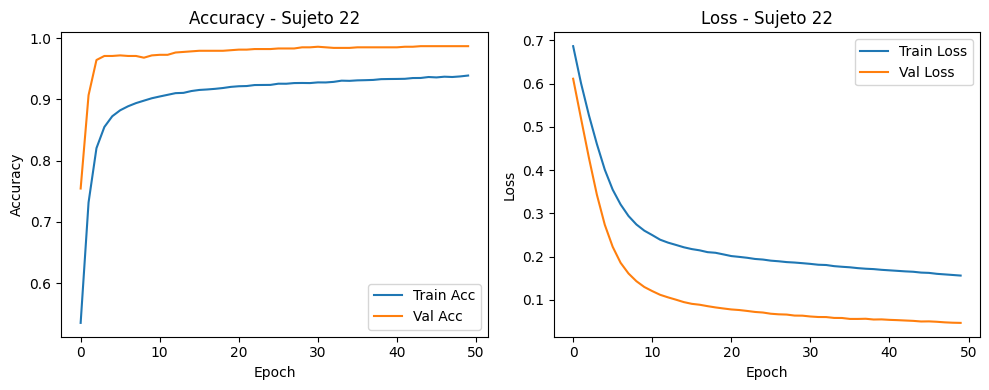

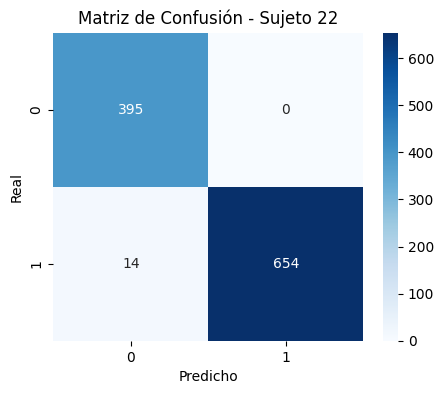

📄 Reporte de clasificación - Sujeto 22
              precision    recall  f1-score   support

           0     0.9658    1.0000    0.9826       395
           1     1.0000    0.9790    0.9894       668

    accuracy                         0.9868      1063
   macro avg     0.9829    0.9895    0.9860      1063
weighted avg     0.9873    0.9868    0.9869      1063


🧪 Validando grupo 23 de 37
Clases en test (sujeto 23): {0: 398, 1: 658}
Epoch 1/50
414/414 [==============================] - 2s 4ms/step - loss: 0.6996 - accuracy: 0.4453 - val_loss: 0.6614 - val_accuracy: 0.5180

Epoch 00001: val_accuracy improved from -inf to 0.51799, saving model to modelos\mejor_modelo_23.h5
Epoch 2/50
414/414 [==============================] - 1s 3ms/step - loss: 0.6109 - accuracy: 0.6325 - val_loss: 0.5515 - val_accuracy: 0.8333

Epoch 00002: val_accuracy improved from 0.51799 to 0.83333, saving model to modelos\mejor_modelo_23.h5
Epoch 3/50
414/414 [==============================] - 1s 3ms/step - loss

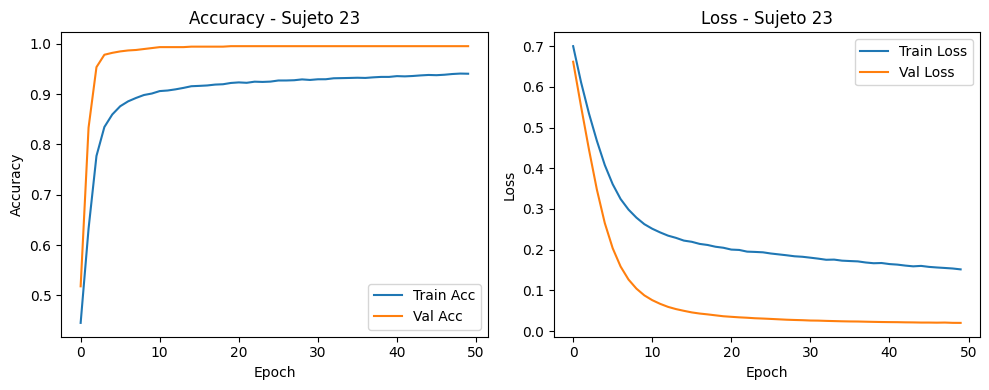

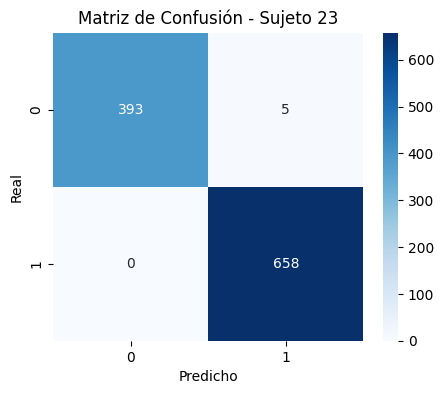

📄 Reporte de clasificación - Sujeto 23
              precision    recall  f1-score   support

           0     1.0000    0.9874    0.9937       398
           1     0.9925    1.0000    0.9962       658

    accuracy                         0.9953      1056
   macro avg     0.9962    0.9937    0.9949      1056
weighted avg     0.9953    0.9953    0.9953      1056


🧪 Validando grupo 24 de 37
Clases en test (sujeto 24): {0: 396, 1: 663}
Epoch 1/50
414/414 [==============================] - 2s 4ms/step - loss: 0.6620 - accuracy: 0.5777 - val_loss: 0.7479 - val_accuracy: 0.3900

Epoch 00001: val_accuracy improved from -inf to 0.38999, saving model to modelos\mejor_modelo_24.h5
Epoch 2/50
414/414 [==============================] - 1s 3ms/step - loss: 0.5927 - accuracy: 0.7124 - val_loss: 0.7570 - val_accuracy: 0.4060

Epoch 00002: val_accuracy improved from 0.38999 to 0.40604, saving model to modelos\mejor_modelo_24.h5
Epoch 3/50
414/414 [==============================] - 1s 3ms/step - loss

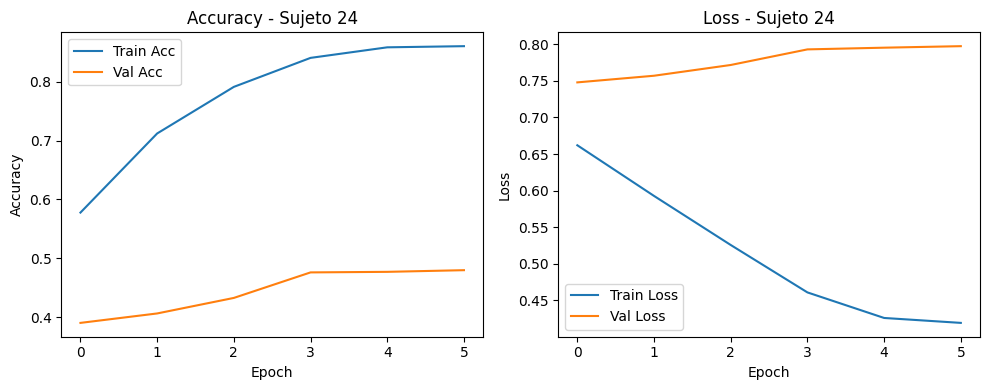

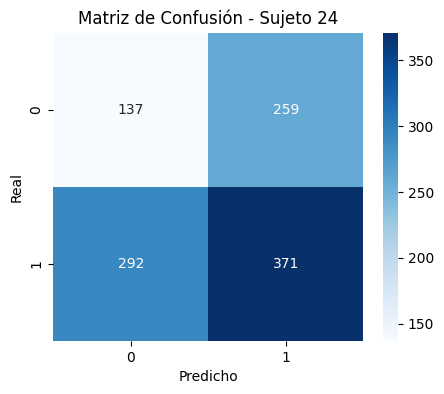

📄 Reporte de clasificación - Sujeto 24
              precision    recall  f1-score   support

           0     0.3193    0.3460    0.3321       396
           1     0.5889    0.5596    0.5739       663

    accuracy                         0.4797      1059
   macro avg     0.4541    0.4528    0.4530      1059
weighted avg     0.4881    0.4797    0.4835      1059


🧪 Validando grupo 25 de 37
Clases en test (sujeto 25): {0: 395, 1: 661}
Epoch 1/50
414/414 [==============================] - 2s 3ms/step - loss: 0.6037 - accuracy: 0.7275 - val_loss: 0.6356 - val_accuracy: 0.6591

Epoch 00001: val_accuracy improved from -inf to 0.65909, saving model to modelos\mejor_modelo_25.h5
Epoch 2/50
414/414 [==============================] - 1s 3ms/step - loss: 0.5309 - accuracy: 0.8009 - val_loss: 0.5962 - val_accuracy: 0.6913

Epoch 00002: val_accuracy improved from 0.65909 to 0.69129, saving model to modelos\mejor_modelo_25.h5
Epoch 3/50
414/414 [==============================] - 1s 3ms/step - loss

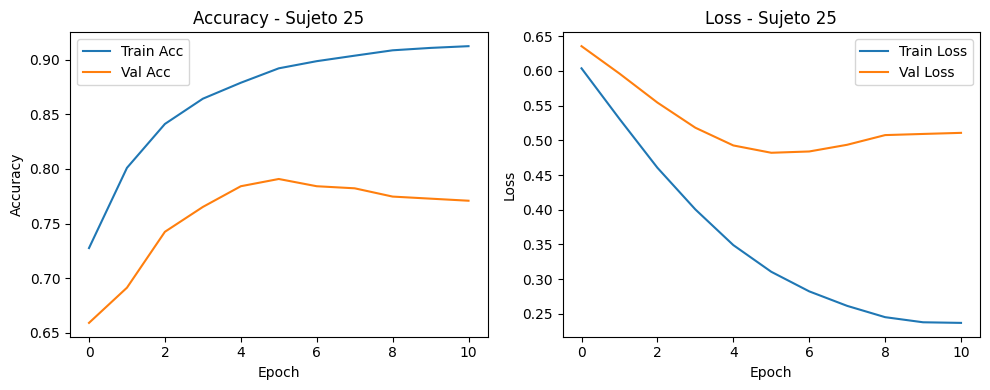

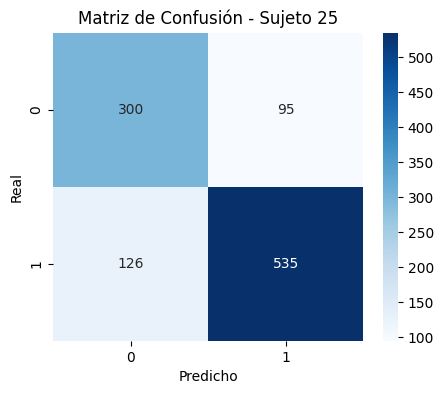

📄 Reporte de clasificación - Sujeto 25
              precision    recall  f1-score   support

           0     0.7042    0.7595    0.7308       395
           1     0.8492    0.8094    0.8288       661

    accuracy                         0.7907      1056
   macro avg     0.7767    0.7844    0.7798      1056
weighted avg     0.7950    0.7907    0.7922      1056


🧪 Validando grupo 26 de 37
Clases en test (sujeto 26): {0: 395, 1: 647}
Epoch 1/50
414/414 [==============================] - 2s 3ms/step - loss: 0.7140 - accuracy: 0.6092 - val_loss: 0.6685 - val_accuracy: 0.5883

Epoch 00001: val_accuracy improved from -inf to 0.58829, saving model to modelos\mejor_modelo_26.h5
Epoch 2/50
414/414 [==============================] - 1s 3ms/step - loss: 0.6252 - accuracy: 0.7149 - val_loss: 0.6034 - val_accuracy: 0.7668

Epoch 00002: val_accuracy improved from 0.58829 to 0.76679, saving model to modelos\mejor_modelo_26.h5
Epoch 3/50
414/414 [==============================] - 1s 3ms/step - loss

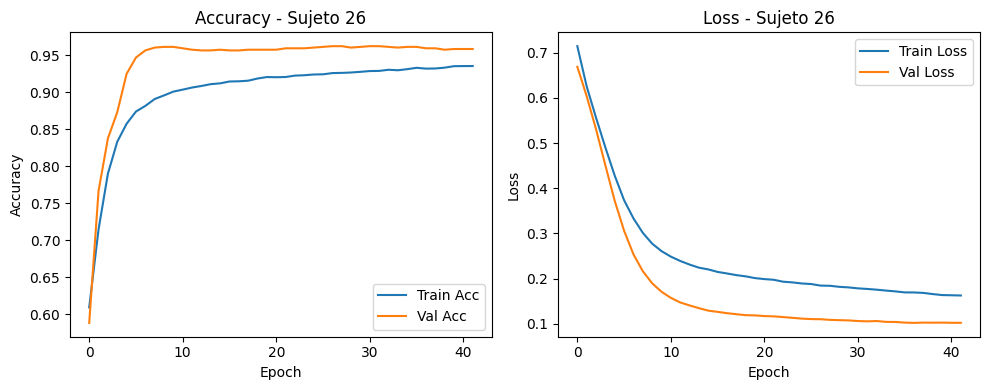

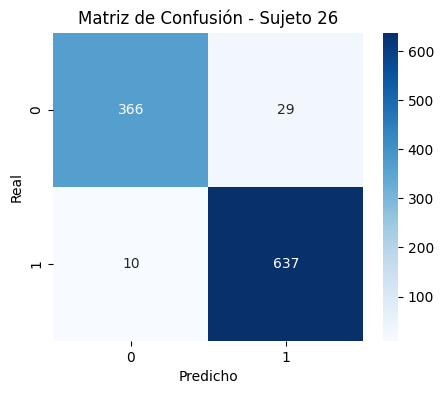

📄 Reporte de clasificación - Sujeto 26
              precision    recall  f1-score   support

           0     0.9734    0.9266    0.9494       395
           1     0.9565    0.9845    0.9703       647

    accuracy                         0.9626      1042
   macro avg     0.9649    0.9556    0.9599      1042
weighted avg     0.9629    0.9626    0.9624      1042


📊 Resultados Finales:
Promedio Accuracy: 0.8900 ± 0.1420
Promedio F1 Score: 0.9090 ± 0.1173

🔍 Análisis Train vs Val:
Diferencia promedio (Val - Train): -0.0416 ± 0.1249
Folds donde Val > Train: 14/26


In [13]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.metrics import f1_score, confusion_matrix, classification_report
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization, Conv1D, MaxPooling1D

accuracies = []
f1_scores = []
train_val_diffs = []  # 🆕 Para analizar diferencias

logo = LeaveOneGroupOut()
split_num = 1

for train_idx, test_idx in logo.split(X_seq, y_seq, groups=subj_seq):
    print(f"\n🧪 Validando grupo {split_num} de {len(np.unique(subjects))}")
    X_train, X_test = X_seq[train_idx], X_seq[test_idx]
    y_train, y_test = y_seq[train_idx], y_seq[test_idx]

    X_train = tf.cast(X_train, tf.float32)
    X_test = tf.cast(X_test, tf.float32)
    y_train = tf.cast(y_train, tf.int32)
    y_test = tf.cast(y_test, tf.int32)

    checkpoint = ModelCheckpoint(f"modelos/mejor_modelo_{split_num}.h5", monitor="val_accuracy", save_best_only=True, verbose=1)
    early_stop = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=3, min_lr=1e-8, verbose=1)
    
    class_weights = compute_class_weight('balanced', classes=np.unique(y_train.numpy()), y=y_train.numpy())
    class_weight_dict = dict(zip(np.unique(y_train.numpy()), class_weights))

    unique, counts = np.unique(y_test, return_counts=True)
    print(f"Clases en test (sujeto {split_num}): {dict(zip(unique, counts))}")

    # 🔄 Modelo con menos regularización
    model = Sequential([
        Conv1D(64, 3, activation='relu', input_shape=(10, 52)),
        MaxPooling1D(2),
        LSTM(32, kernel_regularizer=tf.keras.regularizers.l2(1e-5)),  # 🔄 Menos regularización
        Dropout(0.3),  # 🔄 Menos dropout
        Dense(1, activation='sigmoid')
    ])
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1.0e-5),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )


    with tf.device('/GPU:0'):
        history = model.fit(
            X_train, y_train,
            epochs=50,
            batch_size=64,
            validation_data=(X_test, y_test),
            callbacks=[checkpoint, reduce_lr, early_stop],
            class_weight=class_weight_dict,
            verbose=1
        )

    # Evaluar
    mejor_modelo = load_model(f"modelos/mejor_modelo_{split_num}.h5")
    loss, acc = mejor_modelo.evaluate(X_test, y_test, verbose=0)
    y_pred_prob = mejor_modelo.predict(X_test)
    y_pred = (y_pred_prob > 0.5).astype(int).flatten()

    f1 = f1_score(y_test, y_pred)
    accuracies.append(acc)
    f1_scores.append(f1)

    # 🆕 Encontrar en qué epoch se guardó el mejor modelo
    best_epoch = np.argmax(history.history['val_accuracy']) + 1
    best_val_acc = max(history.history['val_accuracy'])
    final_val_acc = history.history['val_accuracy'][-1]
    final_train_acc = history.history['accuracy'][-1]
    diff = final_val_acc - final_train_acc
    train_val_diffs.append(diff)
    
    print(f"✅ Accuracy: {acc:.4f} - F1: {f1:.4f}")
    print(f"🎯 Mejor modelo guardado en epoch {best_epoch} (Val Acc: {best_val_acc:.4f})")
    print(f"📉 Val Acc final: {final_val_acc:.4f} (diferencia: {final_val_acc - best_val_acc:+.4f})")
    print(f"📊 Train Acc: {final_train_acc:.4f} | Val Acc: {final_val_acc:.4f} | Diff: {diff:+.4f}")

    # ----------------------
    # 🔹 CURVAS DE ENTRENAMIENTO
    # ----------------------
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Acc')
    plt.plot(history.history['val_accuracy'], label='Val Acc')
    plt.title(f'Accuracy - Sujeto {split_num}')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title(f'Loss - Sujeto {split_num}')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()
    # plt.savefig(f'curvas_entrenamiento_sujeto_{split_num}.png')  # Guardar imagen (opcional)

    # ----------------------
    # 🔹 MATRIZ DE CONFUSIÓN Y REPORTE
    # ----------------------
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicho')
    plt.ylabel('Real')
    plt.title(f'Matriz de Confusión - Sujeto {split_num}')
    plt.show()
    # plt.savefig(f'matriz_confusion_sujeto_{split_num}.png')  # Guardar imagen (opcional)

    print(f'📄 Reporte de clasificación - Sujeto {split_num}')
    print(classification_report(y_test, y_pred, digits=4))

    split_num += 1

# ----------------------
# 📊 RESULTADOS FINALES
# ----------------------
print("\n📊 Resultados Finales:")
print(f"Promedio Accuracy: {np.mean(accuracies):.4f} ± {np.std(accuracies):.4f}")
print(f"Promedio F1 Score: {np.mean(f1_scores):.4f} ± {np.std(f1_scores):.4f}")

# 🆕 Análisis de diferencias train/val
print(f"\n🔍 Análisis Train vs Val:")
print(f"Diferencia promedio (Val - Train): {np.mean(train_val_diffs):+.4f} ± {np.std(train_val_diffs):.4f}")
print(f"Folds donde Val > Train: {sum(1 for d in train_val_diffs if d > 0)}/{len(train_val_diffs)}")

✅ Evaluando modelo 1
✅ Evaluando modelo 2
✅ Evaluando modelo 3
✅ Evaluando modelo 4
✅ Evaluando modelo 5
✅ Evaluando modelo 6
✅ Evaluando modelo 7
✅ Evaluando modelo 8
✅ Evaluando modelo 9
✅ Evaluando modelo 10
✅ Evaluando modelo 11
✅ Evaluando modelo 12
✅ Evaluando modelo 13
✅ Evaluando modelo 14
✅ Evaluando modelo 15
✅ Evaluando modelo 16
✅ Evaluando modelo 17
✅ Evaluando modelo 18
✅ Evaluando modelo 19
✅ Evaluando modelo 20
✅ Evaluando modelo 21
✅ Evaluando modelo 22
✅ Evaluando modelo 23
✅ Evaluando modelo 24
✅ Evaluando modelo 25
✅ Evaluando modelo 26

📊 Resultados por sujeto:
    Sujeto  Accuracy  F1 Score              Modelo  class_0  class_1
0        1    0.9008    0.9172   mejor_modelo_1.h5      396      652
1        2    0.9893    0.9913   mejor_modelo_2.h5      395      631
2        3    0.9719    0.9774   mejor_modelo_3.h5      394      637
3        4    0.9148    0.9265   mejor_modelo_4.h5      396      648
4        5    0.9879    0.9900   mejor_modelo_5.h5      395      6

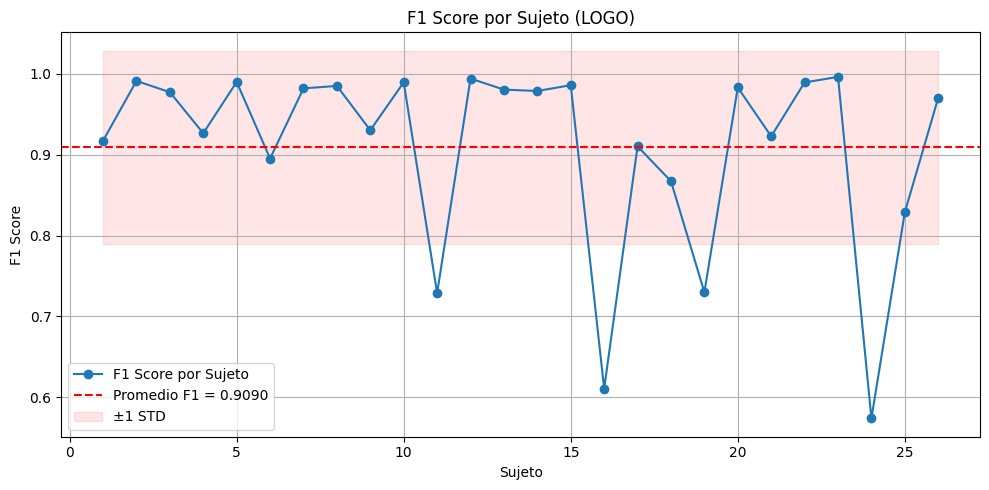


📌 Promedios generales:
Accuracy promedio: 0.8900 ± 0.1448
F1 Score promedio: 0.9090 ± 0.1196


In [14]:
import os
import numpy as np
import tensorflow as tf
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.metrics import f1_score, accuracy_score
from tensorflow.keras.models import load_model
import pandas as pd
import matplotlib.pyplot as plt

# Carpeta donde están tus modelos
MODEL_FOLDER = "modelos"
model_files = sorted([f for f in os.listdir(MODEL_FOLDER) if f.endswith(".h5")])

# Para almacenar resultados
results = []

logo = LeaveOneGroupOut()

split_num = 1
for train_idx, test_idx in logo.split(X_seq, y_seq, groups=subj_seq):
    model_path = os.path.join(MODEL_FOLDER, f"mejor_modelo_{split_num}.h5")
    if not os.path.exists(model_path):
        print(f"❌ Modelo no encontrado: {model_path}")
        split_num += 1
        continue

    print(f"✅ Evaluando modelo {split_num}")
    
    X_test = tf.cast(X_seq[test_idx], tf.float32)
    y_test = y_seq[test_idx]

    model = load_model(model_path)
    y_pred_prob = model.predict(X_test)
    y_pred = (y_pred_prob > 0.5).astype(int).flatten()

    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    unique, counts = np.unique(y_test, return_counts=True)
    class_dist = {f"class_{int(cls)}": int(count) for cls, count in zip(unique, counts)}

    results.append({
        "Sujeto": split_num,
        "Accuracy": acc,
        "F1 Score": f1,
        "Modelo": f"mejor_modelo_{split_num}.h5",
        **class_dist
    })

    split_num += 1

# Convertir a DataFrame
df_resultados = pd.DataFrame(results)

# -----------------------
# 🧾 Tabla resumida
# -----------------------
pd.set_option('display.float_format', lambda x: '%.4f' % x)
print("\n📊 Resultados por sujeto:")
print(df_resultados)

# -----------------------
# 📈 Gráfico resumen
# -----------------------
plt.figure(figsize=(10, 5))
plt.plot(df_resultados["Sujeto"], df_resultados["F1 Score"], marker='o', label="F1 Score por Sujeto")
plt.axhline(df_resultados["F1 Score"].mean(), color='r', linestyle='--', label=f"Promedio F1 = {df_resultados['F1 Score'].mean():.4f}")
plt.fill_between(df_resultados["Sujeto"],
                 df_resultados["F1 Score"].mean() - df_resultados["F1 Score"].std(),
                 df_resultados["F1 Score"].mean() + df_resultados["F1 Score"].std(),
                 color='r', alpha=0.1, label="±1 STD")

plt.title("F1 Score por Sujeto (LOGO)")
plt.xlabel("Sujeto")
plt.ylabel("F1 Score")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# -----------------------
# 🔢 Promedios generales
# -----------------------
print("\n📌 Promedios generales:")
print(f"Accuracy promedio: {df_resultados['Accuracy'].mean():.4f} ± {df_resultados['Accuracy'].std():.4f}")
print(f"F1 Score promedio: {df_resultados['F1 Score'].mean():.4f} ± {df_resultados['F1 Score'].std():.4f}")


In [15]:
# 📈 Análisis estadístico detallado
print("\n" + "="*60)
print("📈 ANÁLISIS ESTADÍSTICO DETALLADO")
print("="*60)

# Estadísticas por métrica
accuracy_stats = df_resultados['Accuracy'].describe()
f1_stats = df_resultados['F1 Score'].describe()

print(f"\n🎯 Estadísticas de Accuracy:")
print(f"   • Mínimo: {accuracy_stats['min']:.4f}")
print(f"   • Q1 (25%): {accuracy_stats['25%']:.4f}")
print(f"   • Mediana: {accuracy_stats['50%']:.4f}")
print(f"   • Q3 (75%): {accuracy_stats['75%']:.4f}")
print(f"   • Máximo: {accuracy_stats['max']:.4f}")
print(f"   • Desviación estándar: {accuracy_stats['std']:.4f}")

print(f"\n🎯 Estadísticas de F1 Score:")
print(f"   • Mínimo: {f1_stats['min']:.4f}")
print(f"   • Q1 (25%): {f1_stats['25%']:.4f}")
print(f"   • Mediana: {f1_stats['50%']:.4f}")
print(f"   • Q3 (75%): {f1_stats['75%']:.4f}")
print(f"   • Máximo: {f1_stats['max']:.4f}")
print(f"   • Desviación estándar: {f1_stats['std']:.4f}")

# Identificar mejores y peores sujetos
best_acc_idx = df_resultados['Accuracy'].idxmax()
worst_acc_idx = df_resultados['Accuracy'].idxmin()
best_f1_idx = df_resultados['F1 Score'].idxmax()
worst_f1_idx = df_resultados['F1 Score'].idxmin()

print(f"\n🏆 Mejores y peores resultados:")
print(f"   • Mejor Accuracy: Sujeto {df_resultados.loc[best_acc_idx, 'Sujeto']} ({df_resultados.loc[best_acc_idx, 'Accuracy']:.4f})")
print(f"   • Peor Accuracy: Sujeto {df_resultados.loc[worst_acc_idx, 'Sujeto']} ({df_resultados.loc[worst_acc_idx, 'Accuracy']:.4f})")
print(f"   • Mejor F1: Sujeto {df_resultados.loc[best_f1_idx, 'Sujeto']} ({df_resultados.loc[best_f1_idx, 'F1 Score']:.4f})")
print(f"   • Peor F1: Sujeto {df_resultados.loc[worst_f1_idx, 'Sujeto']} ({df_resultados.loc[worst_f1_idx, 'F1 Score']:.4f})")

# Confiabilidad del modelo
variability_acc = df_resultados['Accuracy'].std() / df_resultados['Accuracy'].mean()
variability_f1 = df_resultados['F1 Score'].std() / df_resultados['F1 Score'].mean()

print(f"\n📊 Consistencia del modelo (Coeficiente de Variación):")
print(f"   • Accuracy CV: {variability_acc:.4f} ({'Muy consistente' if variability_acc < 0.1 else 'Moderadamente consistente' if variability_acc < 0.2 else 'Variable'})")
print(f"   • F1 Score CV: {variability_f1:.4f} ({'Muy consistente' if variability_f1 < 0.1 else 'Moderadamente consistente' if variability_f1 < 0.2 else 'Variable'})")

# Umbral de rendimiento
good_performance_threshold = 0.8
excellent_performance_threshold = 0.9

good_acc_count = (df_resultados['Accuracy'] >= good_performance_threshold).sum()
excellent_acc_count = (df_resultados['Accuracy'] >= excellent_performance_threshold).sum()
good_f1_count = (df_resultados['F1 Score'] >= good_performance_threshold).sum()
excellent_f1_count = (df_resultados['F1 Score'] >= excellent_performance_threshold).sum()

total_subjects = len(df_resultados)

print(f"\n🎯 Distribución de rendimiento:")
print(f"   • Sujetos con Accuracy ≥ 80%: {good_acc_count}/{total_subjects} ({good_acc_count/total_subjects*100:.1f}%)")
print(f"   • Sujetos con Accuracy ≥ 90%: {excellent_acc_count}/{total_subjects} ({excellent_acc_count/total_subjects*100:.1f}%)")
print(f"   • Sujetos con F1 Score ≥ 80%: {good_f1_count}/{total_subjects} ({good_f1_count/total_subjects*100:.1f}%)")
print(f"   • Sujetos con F1 Score ≥ 90%: {excellent_f1_count}/{total_subjects} ({excellent_f1_count/total_subjects*100:.1f}%)")


📈 ANÁLISIS ESTADÍSTICO DETALLADO

🎯 Estadísticas de Accuracy:
   • Mínimo: 0.4797
   • Q1 (25%): 0.8728
   • Mediana: 0.9672
   • Q3 (75%): 0.9824
   • Máximo: 0.9953
   • Desviación estándar: 0.1448

🎯 Estadísticas de F1 Score:
   • Mínimo: 0.5739
   • Q1 (25%): 0.8990
   • Mediana: 0.9738
   • Q3 (75%): 0.9858
   • Máximo: 0.9962
   • Desviación estándar: 0.1196

🏆 Mejores y peores resultados:
   • Mejor Accuracy: Sujeto 23 (0.9953)
   • Peor Accuracy: Sujeto 24 (0.4797)
   • Mejor F1: Sujeto 23 (0.9962)
   • Peor F1: Sujeto 24 (0.5739)

📊 Consistencia del modelo (Coeficiente de Variación):
   • Accuracy CV: 0.1627 (Moderadamente consistente)
   • F1 Score CV: 0.1316 (Moderadamente consistente)

🎯 Distribución de rendimiento:
   • Sujetos con Accuracy ≥ 80%: 21/26 (80.8%)
   • Sujetos con Accuracy ≥ 90%: 18/26 (69.2%)
   • Sujetos con F1 Score ≥ 80%: 22/26 (84.6%)
   • Sujetos con F1 Score ≥ 90%: 19/26 (73.1%)
